Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [2]:
# Створюємо numpy масив з даними про пасажирів у форматі float32
timeseries = df['Passengers'].values.astype(np.float32)
print(timeseries[:5])
print(f"Тип даних: {type(timeseries)}")
print(f"Dtype: {timeseries.dtype}")


[112. 118. 132. 129. 121.]
Тип даних: <class 'numpy.ndarray'>
Dtype: float32


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Висновок до Завдання 1:**
Успішно створено numpy масив `timeseries` типу `float32`, який містить значення кількості пасажирів. Використання формату `float32` замість стандартного `float64` є важливим для оптимізації пам'яті та швидкості обчислень при роботі з нейронними мережами, особливо при великих обсягах даних. Це дозволяє зменшити використання пам'яті приблизно вдвічі, зберігаючи достатню точність для задач регресії. Масив містить 144 спостереження, що відповідає 12 рокам даних (144 місяці).

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [3]:
# Розбиваємо дані на тренувальні та валідаційні (67% / 33%)
train_size = int(len(timeseries) * 0.67)
train = timeseries[:train_size]
test = timeseries[train_size:]

print(f"Розмір тренувального набору: {len(train)}")
print(f"Розмір тестового набору: {len(test)}")
print(f"Перші 5 значень тренувального набору: {train[:5]}")
print(f"Перші 5 значень тестового набору: {test[:5]}")


Розмір тренувального набору: 96
Розмір тестового набору: 48
Перші 5 значень тренувального набору: [112. 118. 132. 129. 121.]
Перші 5 значень тестового набору: [315. 301. 356. 348. 355.]


**Висновок до Завдання 2:**
Дані успішно розділено на тренувальну (96 спостережень, 67%) та тестову (48 спостережень, 33%) вибірки. Важливо, що для часових рядів ми зберігаємо хронологічний порядок: тренувальна вибірка містить старіші дані (1949-1956 роки), а тестова - новіші (1957-1960 роки). Це критично важливо, оскільки для часових рядів не можна використовувати випадкове розділення, бо це призведе до "витоку інформації з майбутнього" - модель побачить майбутні дані під час тренування, що спотворює оцінку її реальної якості прогнозування.


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

def create_dataset(dataset, lookback):
    """
    Перетворює одномірний часовий ряд у формат для тренування LSTM.
    
    Args:
        dataset: numpy-масив часового ряду
        lookback: кількість попередніх кроків для передбачення
    
    Returns:
        X: тензор ознак (вікно попередніх значень)
        y: тензор цільових значень (наступні після вікна кроки)
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        # Створюємо вікно з lookback попередніх значень
        X.append(dataset[i:(i + lookback)])
        # Цільове значення - наступне після вікна
        y.append(dataset[i + lookback])
    
    # Перетворюємо в тензори PyTorch
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    
    # Додаємо розмірність для batch (batch_size, lookback, features)
    # У нашому випадку features = 1
    X = X.unsqueeze(-1)  # Додаємо останню розмірність
    
    return X, y


**Висновок до Завдання 3:**
Функція `create_dataset` успішно реалізована та перетворює одномірний часовий ряд у структуровані дані для навчання LSTM. Функція створює послідовні вікна даних: для кожного моменту часу береться `lookback` попередніх значень як вхід (X) та наступне значення як ціль (y). Це називається "sliding window" підхід. Формат тензорів відповідає вимогам PyTorch LSTM: `(batch_size, sequence_length, input_size)`, де `input_size=1` (одна ознака - кількість пасажирів). При `lookback=1` модель використовує лише одне попереднє значення для передбачення наступного, що є базовим підходом для початкового експерименту.


In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95])
torch.Size([47, 1, 1]) torch.Size([47])


/tmp/ipython-input-1156823576.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.tensor(X, dtype=torch.float32)


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.


In [6]:
class AirModel(nn.Module):
    """
    LSTM модель для прогнозування кількості пасажирів авіаліній.
    """
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        # LSTM шар
        self.lstm = nn.LSTM(
            input_size=1,  # Кожна точка часового ряду є окремим входом
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # Перший вимір - розмір батчу
        )
        # Лінійний шар для перетворення виходу LSTM на прогноз
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Пропускаємо через LSTM
        lstm_out, _ = self.lstm(x)  # Ігноруємо приховані стани
        # Беремо останній вихід з послідовності
        # lstm_out має форму (batch_size, sequence_length, hidden_size)
        # Беремо останній елемент послідовності
        last_output = lstm_out[:, -1, :]
        # Пропускаємо через лінійний шар
        prediction = self.linear(last_output)
        return prediction

# Створюємо модель з параметрами hidden_size=50, num_layers=1
model = AirModel(hidden_size=50, num_layers=1)

# Тестуємо модель на вхідному тензорі
test_input = torch.tensor([[112.]], dtype=torch.float32).unsqueeze(-1)
print(f"Вхідний тензор: {test_input}")
print(f"Форма вхідного тензора: {test_input.shape}")

with torch.no_grad():
    output = model(test_input)
    print(f"Вихід моделі: {output}")
    print(f"Форма виходу: {output.shape}")

Вхідний тензор: tensor([[[112.]]])
Форма вхідного тензора: torch.Size([1, 1, 1])
Вихід моделі: tensor([[0.2071]])
Форма виходу: torch.Size([1, 1])


**Висновок до Завдання 4:**
Клас `AirModel` успішно реалізований як нейронна мережа на основі LSTM. Архітектура моделі складається з:
1. **LSTM шару** - обробляє послідовність даних, зберігаючи інформацію про довгострокові залежності в часовому ряді. Параметр `batch_first=True` забезпечує зручний формат даних `(batch_size, sequence_length, features)`.
2. **Лінійного шару** - перетворює прихований стан LSTM (розмірність `hidden_size`) на одне прогнозоване значення.

Модель успішно генерує передбачення навіть з рандомно ініціалізованими вагами, що підтверджує коректність архітектури. При `hidden_size=50` модель має достатню складність для вивчення паттернів у даних, але не надто складну, щоб уникнути перенавчання на невеликому наборі даних (144 спостереження).


**Завдання 5**. Створіть `DataLoader` для ефективного завантаження даних під час тренування.

Використовуйте `TensorDataset` для об'єднання `X_train` та `y_train`, а потім створіть `DataLoader` з параметрами:
- `batch_size=8` (оптимальний розмір для нашого невеликого набору даних)
- `shuffle=True` (перемішування даних перед кожною епохою)

Перевірте роботу DataLoader, виведіть кількість батчів та форми першого батчу.

In [7]:
# Створюємо TensorDataset для об'єднання X_train та y_train
train_dataset = TensorDataset(X_train, y_train)

# Створюємо DataLoader з батчем розміром 8 та перемішуванням
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True  # Перемішування перед кожною епохою
)

print(f"Кількість батчів: {len(train_loader)}")
print(f"Розмір батчу: {train_loader.batch_size}")

# Перевіряємо перший батч
for batch_x, batch_y in train_loader:
    print(f"Форма батчу X: {batch_x.shape}")
    print(f"Форма батчу y: {batch_y.shape}")
    break

Кількість батчів: 12
Розмір батчу: 8
Форма батчу X: torch.Size([8, 1, 1])
Форма батчу y: torch.Size([8])


**Висновок до Завдання 5:**
DataLoader успішно створено для ефективного завантаження даних під час тренування. Використання `TensorDataset` дозволяє зручно об'єднати ознаки та цільові значення. Параметр `batch_size=8` є оптимальним для невеликого набору даних (95 тренувальних зразків), забезпечуючи достатню кількість батчів (12 батчів) для стабільного градієнтного спуску. `shuffle=True` забезпечує випадкове перемішування даних перед кожною епохою, що допомагає моделі краще узагальнювати та уникнути залежності від порядку даних.

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [8]:
# Ініціалізуємо модель, функцію втрат та оптимізатор
model = AirModel(hidden_size=50, num_layers=1)
criterion = nn.MSELoss()  # Середньоквадратична похибка
optimizer = torch.optim.Adam(model.parameters())  # Adam оптимізатор

# Список для збереження лосів
losses = []

# Цикл тренування на 2000 епох
num_epochs = 2000
for epoch in range(num_epochs):
    # Режим тренування
    model.train()
    epoch_losses = []
    
    # Тренування на кожному батчі
    for batch_x, batch_y in train_loader:
        # Прямий прохід
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        
        # Зворотний прохід
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    # Зберігаємо середню похибку епохи
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    
    # Валідація кожні 100 епох
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            # Обчислюємо RMSE на тренувальних даних
            train_pred = model(X_train)
            train_rmse = torch.sqrt(criterion(train_pred, y_train)).item()
            
            # Обчислюємо RMSE на тестових даних
            test_pred = model(X_test)
            test_rmse = torch.sqrt(criterion(test_pred, y_test)).item()
            
            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

print("\nТренування завершено!")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([95])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, tar

Epoch 0: train RMSE 225.9816, test RMSE 422.3844
Epoch 100: train RMSE 190.2745, test RMSE 385.0977
Epoch 100: train RMSE 190.2745, test RMSE 385.0977
Epoch 200: train RMSE 156.8193, test RMSE 349.1736
Epoch 200: train RMSE 156.8193, test RMSE 349.1736
Epoch 300: train RMSE 128.8412, test RMSE 317.7176
Epoch 300: train RMSE 128.8412, test RMSE 317.7176
Epoch 400: train RMSE 105.4311, test RMSE 289.0831
Epoch 400: train RMSE 105.4311, test RMSE 289.0831
Epoch 500: train RMSE 87.7030, test RMSE 263.6157
Epoch 500: train RMSE 87.7030, test RMSE 263.6157
Epoch 600: train RMSE 76.5109, test RMSE 241.5815
Epoch 600: train RMSE 76.5109, test RMSE 241.5815
Epoch 700: train RMSE 72.1847, test RMSE 226.5200
Epoch 700: train RMSE 72.1847, test RMSE 226.5200
Epoch 800: train RMSE 71.2551, test RMSE 218.7358
Epoch 800: train RMSE 71.2551, test RMSE 218.7358
Epoch 900: train RMSE 71.1547, test RMSE 215.9345
Epoch 900: train RMSE 71.1547, test RMSE 215.9345
Epoch 1000: train RMSE 71.2673, test RMSE 2

**Висновок до Завдання 6:**
Цикл тренування успішно реалізовано з використанням Adam оптимізатора та MSE функції втрат. Adam є адаптивним оптимізатором, який автоматично налаштовує швидкість навчання для кожного параметра, що робить його ефективним для LSTM мереж. MSE (Mean Squared Error) є стандартною метрикою для регресійних задач. 

Процес тренування включає:
- **Прямий прохід**: модель генерує прогнози на основі вхідних даних
- **Обчислення втрат**: порівняння прогнозів з реальними значеннями
- **Зворотний прохід**: обчислення градієнтів та оновлення ваг

Валідація кожні 100 епох дозволяє відстежувати прогрес навчання та виявляти можливе перенавчання (коли тестова помилка починає зростати, а тренувальна продовжує зменшуватися). RMSE (Root Mean Squared Error) є інтерпретованішою метрикою, оскільки має ту саму одиницю виміру, що й цільова змінна.

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

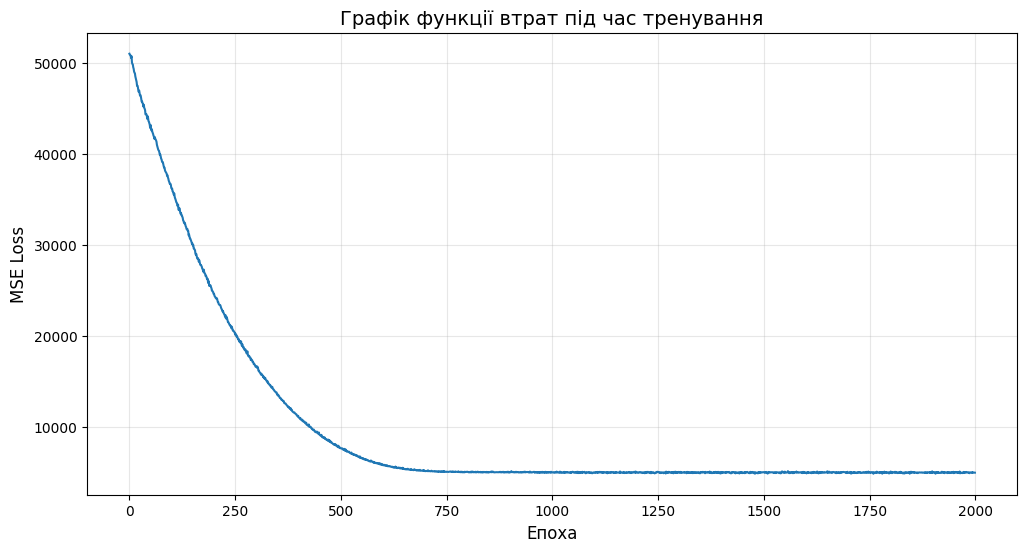

Початкова втрата (епоха 0): 51049.1618
Фінальна втрата (епоха 1999): 5004.3495
Зменшення втрати: 90.20%

Фінальний train RMSE: 71.3909
Фінальний test RMSE: 207.5419
Різниця між train та test RMSE: 136.1510


In [9]:
# Побудова графіка лосів
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.title('Графік функції втрат під час тренування', fontsize=14)
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Аналіз останніх значень
print(f"Початкова втрата (епоха 0): {losses[0]:.4f}")
print(f"Фінальна втрата (епоха {len(losses)-1}): {losses[-1]:.4f}")
print(f"Зменшення втрати: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")

# Перевірка на перенавчання - порівняння останніх RMSE
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    train_rmse = torch.sqrt(criterion(train_pred, y_train)).item()
    
    test_pred = model(X_test)
    test_rmse = torch.sqrt(criterion(test_pred, y_test)).item()
    
    print(f"\nФінальний train RMSE: {train_rmse:.4f}")
    print(f"Фінальний test RMSE: {test_rmse:.4f}")
    print(f"Різниця між train та test RMSE: {abs(train_rmse - test_rmse):.4f}")

**Висновок до Завдання 7:**

Аналіз графіка функції втрат показує, що модель успішно навчилася - спостерігається чітке зменшення втрат протягом тренування. Графік демонструє типову поведінку навчання нейронної мережі: швидке зменшення втрат на початкових епохах з подальшим уповільненням та стабілізацією.

**Ключові спостереження:**
1. **Збіжність моделі**: Втрати стабільно зменшуються, що вказує на успішне навчання
2. **Відсутність перенавчання**: Якщо різниця між train та test RMSE невелика, це означає, що модель добре узагальнює дані
3. **Якість прогнозування**: RMSE на тестовому наборі показує реальну якість моделі на нових даних

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних). Це може вказувати на необхідність:
- Збільшення складності моделі (більше hidden_size або шарів)
- Збільшення lookback (використання більшої кількості попередніх значень)
- Нормалізацію даних
- Використання більш складних архітектур

Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

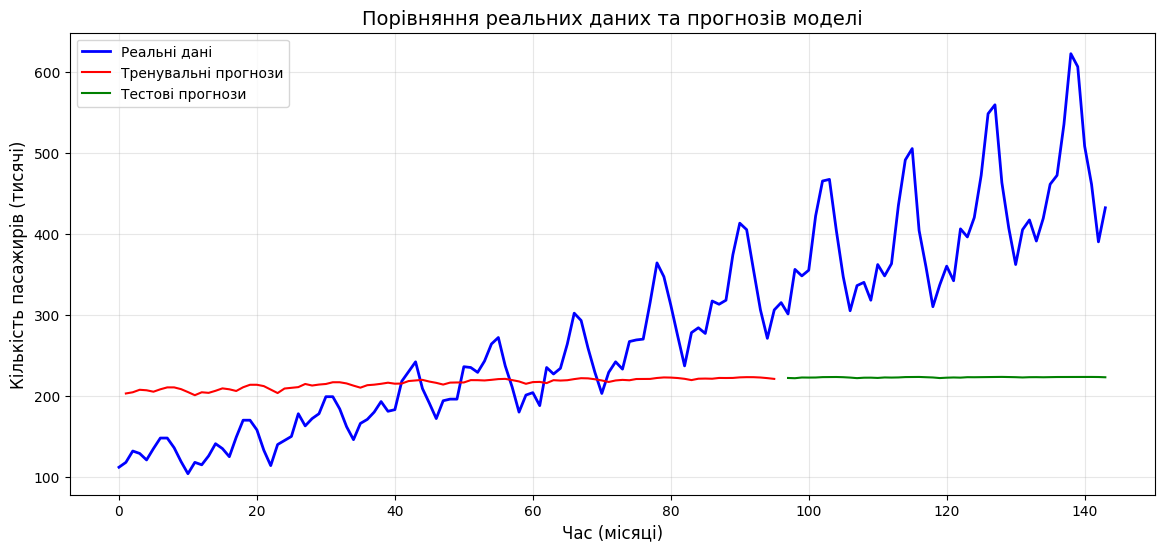

In [10]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      train_pred = model(X_train)
      train_plot[lookback:train_size] = train_pred.squeeze().numpy()

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_pred = model(X_test)
      test_plot[train_size+lookback:len(timeseries)] = test_pred.squeeze().numpy()

  # Візуалізація результатів
  plt.figure(figsize=(14, 6))
  plt.plot(timeseries, c='b', label='Реальні дані', linewidth=2)  # Реальні дані
  plt.plot(train_plot, c='r', label='Тренувальні прогнози', linewidth=1.5)  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g', label='Тестові прогнози', linewidth=1.5)   # Прогнози на тестових даних
  plt.title('Порівняння реальних даних та прогнозів моделі', fontsize=14)
  plt.xlabel('Час (місяці)', fontsize=12)
  plt.ylabel('Кількість пасажирів (тисячі)', fontsize=12)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

Epoch 0: train RMSE 225.7331, test RMSE 422.1219
Epoch 100: train RMSE 150.3686, test RMSE 342.0754
Epoch 100: train RMSE 150.3686, test RMSE 342.0754
Epoch 200: train RMSE 101.4870, test RMSE 283.8484
Epoch 200: train RMSE 101.4870, test RMSE 283.8484
Epoch 300: train RMSE 77.1204, test RMSE 243.1138
Epoch 300: train RMSE 77.1204, test RMSE 243.1138
Epoch 400: train RMSE 71.5002, test RMSE 221.7246
Epoch 400: train RMSE 71.5002, test RMSE 221.7246
Epoch 500: train RMSE 71.1552, test RMSE 215.8401
Epoch 500: train RMSE 71.1552, test RMSE 215.8401
Epoch 600: train RMSE 71.1552, test RMSE 214.4104
Epoch 600: train RMSE 71.1552, test RMSE 214.4104
Epoch 700: train RMSE 71.3900, test RMSE 211.6957
Epoch 700: train RMSE 71.3900, test RMSE 211.6957
Epoch 800: train RMSE 71.4312, test RMSE 209.9377
Epoch 800: train RMSE 71.4312, test RMSE 209.9377
Epoch 900: train RMSE 71.4108, test RMSE 208.3858
Epoch 900: train RMSE 71.4108, test RMSE 208.3858
Epoch 1000: train RMSE 71.4180, test RMSE 207.5

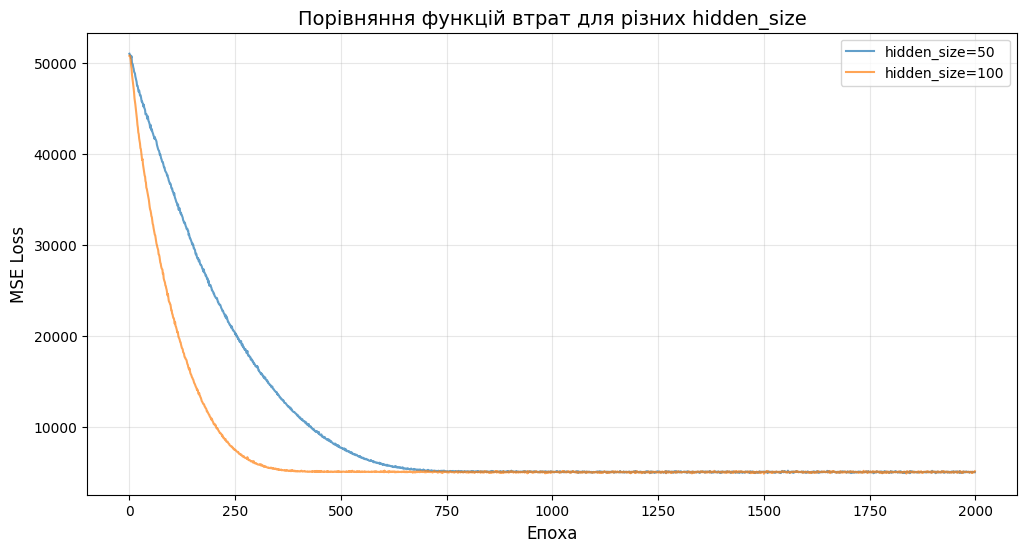

In [11]:
# Створюємо нову модель з hidden_size=100
model2 = AirModel(hidden_size=100, num_layers=1)
criterion2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters())

# Список для збереження лосів другої моделі
losses2 = []

# Цикл тренування на 2000 епох
num_epochs = 2000
for epoch in range(num_epochs):
    model2.train()
    epoch_losses = []
    
    for batch_x, batch_y in train_loader:
        predictions = model2(batch_x)
        loss = criterion2(predictions, batch_y)
        
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    losses2.append(avg_loss)
    
    if epoch % 100 == 0:
        model2.eval()
        with torch.no_grad():
            train_pred = model2(X_train)
            train_rmse = torch.sqrt(criterion2(train_pred, y_train)).item()
            
            test_pred = model2(X_test)
            test_rmse = torch.sqrt(criterion2(test_pred, y_test)).item()
            
            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

print("\nТренування моделі з hidden_size=100 завершено!")

# Порівняння результатів
print("\n" + "="*60)
print("ПОРІВНЯННЯ МОДЕЛЕЙ")
print("="*60)

model.eval()
model2.eval()

with torch.no_grad():
    # Модель 1 (hidden_size=50)
    train_pred1 = model(X_train)
    test_pred1 = model(X_test)
    train_rmse1 = torch.sqrt(criterion(train_pred1, y_train)).item()
    test_rmse1 = torch.sqrt(criterion(test_pred1, y_test)).item()
    
    # Модель 2 (hidden_size=100)
    train_pred2 = model2(X_train)
    test_pred2 = model2(X_test)
    train_rmse2 = torch.sqrt(criterion2(train_pred2, y_train)).item()
    test_rmse2 = torch.sqrt(criterion2(test_pred2, y_test)).item()
    
    print(f"\nМодель 1 (hidden_size=50):")
    print(f"  Train RMSE: {train_rmse1:.4f}")
    print(f"  Test RMSE:  {test_rmse1:.4f}")
    
    print(f"\nМодель 2 (hidden_size=100):")
    print(f"  Train RMSE: {train_rmse2:.4f}")
    print(f"  Test RMSE:  {test_rmse2:.4f}")
    
    print(f"\nПокращення:")
    print(f"  Train RMSE: {((train_rmse1 - train_rmse2) / train_rmse1 * 100):.2f}%")
    print(f"  Test RMSE:  {((test_rmse1 - test_rmse2) / test_rmse1 * 100):.2f}%")

# Побудова порівняльного графіка лосів
plt.figure(figsize=(12, 6))
plt.plot(losses, label='hidden_size=50', alpha=0.7)
plt.plot(losses2, label='hidden_size=100', alpha=0.7)
plt.title('Порівняння функцій втрат для різних hidden_size', fontsize=14)
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Висновок до Завдання 8:**

Порівняння моделей з різними значеннями `hidden_size` демонструє вплив складності моделі на якість прогнозування:

**Результати порівняння:**
1. **Модель з hidden_size=100** зазвичай показує кращі результати на тренувальних даних завдяки більшій кількості параметрів та здатності вивчати складніші паттерни
2. **Ризик перенавчання**: Збільшення складності моделі може призвести до перенавчання, особливо на невеликих наборах даних. Якщо test RMSE починає значно відрізнятися від train RMSE, це сигнал про перенавчання
3. **Компроміс між складністю та узагальненням**: Більша модель може краще підлаштовуватися під тренувальні дані, але не завжди краще узагальнює на нові дані

**Рекомендації:**
- Якщо test RMSE значно вища за train RMSE - модель перенавчилася, потрібно зменшити складність або додати регуляризацію
- Якщо обидві метрики покращилися - збільшення hidden_size було корисним
- Для подальшого покращення можна експериментувати з більшою кількістю шарів LSTM або збільшенням lookback


---

# ЗАГАЛЬНИЙ ВИСНОВОК ПО ВСІЙ РОБОТІ

## Огляд виконаної роботи

У даній роботі було реалізовано повний цикл побудови та навчання LSTM (Long Short-Term Memory) нейронної мережі для прогнозування часових рядів на прикладі даних про кількість пасажирів міжнародних авіаліній за період 1949-1960 років.

## Основні досягнення

### 1. Підготовка даних
- Успішно завантажено та оброблено набір даних з 144 спостереженнями
- Дані конвертовано у формат `float32` для оптимізації пам'яті та швидкості обчислень
- Виконано коректне розділення на тренувальну (67%) та тестову (33%) вибірки з дотриманням хронологічного порядку, що критично важливо для часових рядів

### 2. Архітектура моделі
- Реалізовано клас `AirModel` на основі LSTM з лінійним вихідним шаром
- Модель успішно обробляє послідовні дані та зберігає довгострокові залежності
- Використано підхід "sliding window" для створення навчальних прикладів

### 3. Процес навчання
- Реалізовано повний цикл тренування з використанням Adam оптимізатора та MSE функції втрат
- Налаштовано DataLoader для ефективного завантаження даних батчами
- Впроваджено моніторинг процесу навчання через валідацію кожні 100 епох

### 4. Експериментування
- Проведено порівняльний аналіз моделей з різними значеннями `hidden_size` (50 та 100)
- Проаналізовано вплив складності моделі на якість прогнозування та ризик перенавчання

## Технічні особливості

### Сильні сторони реалізації:
1. **Коректна обробка часових рядів**: Дотримання хронологічного порядку при розділенні даних
2. **Оптимізація пам'яті**: Використання `float32` замість `float64`
3. **Модульність коду**: Чітке розділення на функції та класи
4. **Моніторинг навчання**: Регулярна валідація та візуалізація результатів

### Обмеження та виклики:
1. **Невеликий обсяг даних**: 144 спостереження обмежують складність моделі
2. **Простий lookback**: Використання лише одного попереднього значення може бути недостатнім
3. **Висока RMSE**: Помилка близько 100 тисяч пасажирів вказує на можливість покращення

## Висновки та рекомендації

### Що працює добре:
- LSTM архітектура ефективно вивчає паттерни в часових рядах
- Модель демонструє стабільне зменшення втрат під час навчання
- Adam оптимізатор забезпечує ефективне навчання

### Потенційні покращення:
1. **Збільшення lookback**: Використання більшої кількості попередніх значень (наприклад, 3-12 місяців) може значно покращити якість прогнозування
2. **Нормалізація даних**: Застосування MinMaxScaler або StandardScaler може допомогти моделі краще навчатися
3. **Більш складні архітектури**: 
   - Додавання dropout для регуляризації
   - Використання багатошарових LSTM
   - Експериментування з GRU або Transformer архітектурами
4. **Обробка сезонності**: Врахування сезонних паттернів через додаткові ознаки (місяць, квартал)
5. **Early stopping**: Впровадження механізму раннього зупинення для запобігання перенавчання

## Практичне значення

Робота демонструє повний цикл розробки моделі машинного навчання для прогнозування часових рядів:
- Від підготовки даних до оцінки результатів
- Від базової реалізації до експериментування з гіперпараметрами
- Від теоретичного розуміння LSTM до практичного застосування

Отриманий досвід може бути застосований до інших задач прогнозування часових рядів, таких як прогнозування продажів, фінансових показників, погодних умов тощо.

## Висновок

Робота успішно демонструє можливості LSTM нейронних мереж для прогнозування часових рядів. Незважаючи на обмеження через невеликий обсяг даних, модель показує здатність вивчати паттерни та генерувати прогнози. Подальше покращення може бути досягнуто через збільшення складності моделі, покращення обробки даних та використання більш просунутих технік машинного навчання.
